**Artificial recurrent neural network LSTM is long short term memory which is used to predict the stock price**

# IMPORTING LIBRARIES

In [1]:
import pandas as pd
import math
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt 
plt.style.use('fivethirtyeight')
import pandas_datareader as web

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
from keras.models import Sequential
from keras.layers import Dense,LSTM

Using TensorFlow backend.


# Taking Data from web Cleaning it

In [3]:
df=web.DataReader('AAPL',data_source='yahoo', start='2008-01-01', end='2020-01-01')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2008-01-02,28.608572,27.507143,28.467142,27.834286,269794700.0,24.096073
2008-01-03,28.198572,27.527143,27.915714,27.847143,210516600.0,24.107191
2008-01-04,27.571428,25.555714,27.350000,25.721428,363958000.0,22.266973
2008-01-07,26.228571,24.318571,25.892857,25.377142,518048300.0,21.968927
2008-01-08,26.065714,24.400000,25.734285,24.464285,380954000.0,21.178667
...,...,...,...,...,...,...
2019-12-24,284.890015,282.920013,284.690002,284.269989,12119700.0,282.831299
2019-12-26,289.980011,284.700012,284.820007,289.910004,23280300.0,288.442780
2019-12-27,293.970001,288.119995,291.119995,289.799988,36566500.0,288.333313


In [0]:
#taking only 1 column
data=df.filter(['Close'])
#converting to numpy array
dataset=data.values

# Visualizing the closing price history

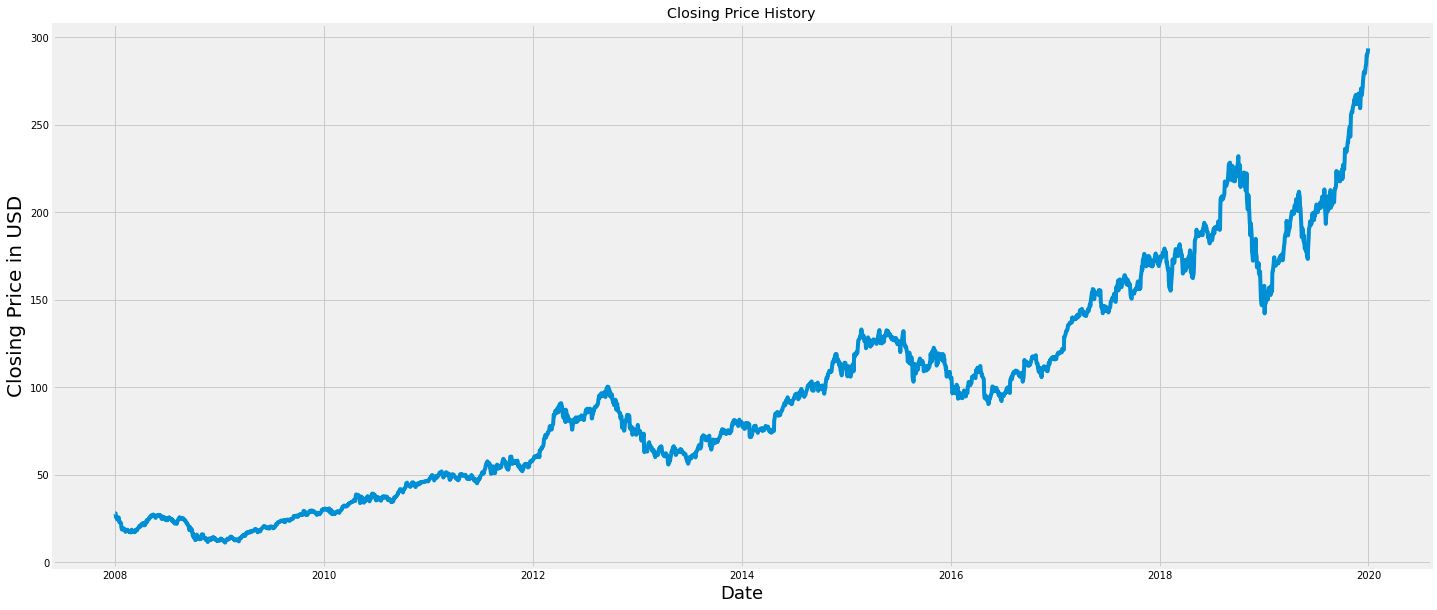

In [5]:
plt.figure(figsize=(22,10))
plt.title('Closing Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize = 18)
plt.ylabel('Closing Price in USD',fontsize = 20)
plt.show()

# Preprocessing

In [6]:
#get number of rows to train the model on
#traing on 90% of the data
#math.dataceil to round up
training_data_len=math.ceil(len(dataset)*0.9)
training_data_len

2719

In [7]:
#scale the data
scalar = MinMaxScaler(feature_range=(0,1))
#transform b/w 0 and 1
scaled_data = scalar.fit_transform(dataset)
scaled_data

array([[0.05898804],
       [0.05903356],
       [0.05150833],
       ...,
       [0.98637063],
       [0.99245959],
       [1.        ]])

In [0]:
#create scaled traing dataset
train_data=scaled_data[0:training_data_len,:]
#split the data
x_train=[]
y_train=[]


#for every 60 values we want to predict 61st value
#for next 60 days we want to predict using 120 days data
#in 2nd pass through we will take 2nd number as 1st and 61st as 60th
for i in range(60,len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])

In [0]:
#convert sets to numpy arrays
x_train,y_train=np.array(x_train),np.array(y_train)

In [10]:
#reshape the data so that we can get a 3d data from a 2d data
x_train=np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train.shape

(2659, 60, 1)

In [0]:
#BUILD the LSTM model we added a secon LSTM layer of 50 neurons
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(60,1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compiling the Model

In [0]:
#optimiser is used to improve and loss is used to measure how well the model performed 
model.compile(optimizer='adam',loss='mean_squared_error')

In [13]:
#trailing the model
model.fit(x_train,y_train, batch_size=1,epochs=1 )

Epoch 1/1
2659/2659 [==============================] - 110s 42ms/step - loss: 6.0996e-04


In [0]:
#create the testing dataset
#letscreate a new array from 2659 to 3021
test_data=scaled_data[training_data_len-60: , :]
#create the new datasets x_test, y_test 
x_test=[]
y_test=dataset[training_data_len: ,:]
for i in range(60,len(test_data)):
  x_test.append(test_data[i-60:i,0])

#converting to np array
x_test=np.array(x_test)

In [0]:
#reshape the data 
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

# Predictions

In [0]:
predictions = model.predict(x_test)
#now we will inverse transform the data
predictions=scalar.inverse_transform(predictions)
#we are descaling the values as we want them to be similar to y_ test dataset

In [17]:
#get the root mean squared error (rmse)
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
#if would have been 0 it would have been accurate 
rmse 

6.195590982960156

# **Visualization**

In [26]:
train=data[:training_data_len]
valid=data[training_data_len:]
valid['Predictions']=predictions


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


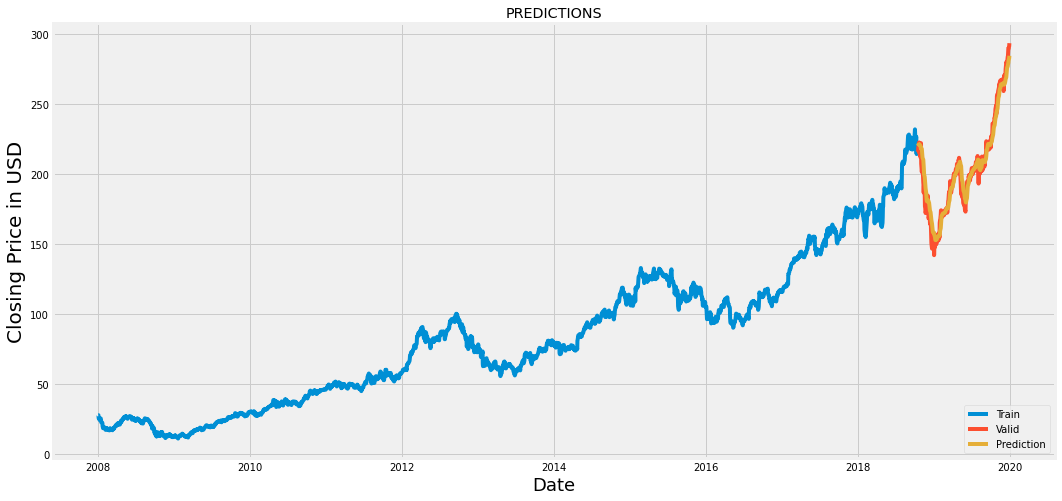

In [28]:
plt.figure(figsize=(16,8))
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

plt.title('PREDICTIONS')
plt.xlabel('Date',fontsize = 18)
plt.ylabel('Closing Price in USD',fontsize = 20)
plt.legend(['Train','Valid','Prediction'],loc='lower right')
plt.show()


In [29]:
valid

,Close,Predictions
Date,,
2018-10-18,216.020004,222.082550
2018-10-19,219.309998,221.493500
2018-10-22,220.649994,221.155228
2018-10-23,222.729996,221.121445
2018-10-24,215.089996,221.483307
...,...,...
2019-12-24,284.269989,278.381592
2019-12-26,289.910004,279.571075
2019-12-27,289.799988,281.264587


# **PREDICTING**

In [31]:
newdf=web.DataReader('AAPL',data_source='yahoo', start='2008-01-01', end='2020-01-01')
#taking only 1 column
data=newdf.filter(['Close'])
#converting to numpy array
last60days=data[-60:].values
last60days=scalar.transform(last60days)
X_test=[]
X_test.append(last60days)
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
pred_price=model.predict(X_test)
pred_price=scalar.inverse_transform(pred_price)
#this is the predicted closing price of 1-1-2020
print(pred_price)


[[286.40643]]


In [38]:
k=web.DataReader('AAPL',data_source='yahoo', start='2019-12-31', end='2020-01-01')
print(k['Close'])

Date
2019-12-31    293.649994
Name: Close, dtype: float64
